# **Skin Depth**
**Elaborado por:** \
Ivan Camilo Caballero Jaimes 2210623\
Johan Enrique Páez Romero 2210631\
Semillero de Investigación en Geofísica Aplicada y Computacional - **SIGAC**

## Descripción General

En este cuaderno se pretende conocer la profundidad de aquisición (skin depth) para diferentes modelos. Entendiendo cómo la profundidad depende de propiedades del medio y de las frecuencias de adquisición. 

### Problema 

Tenemos un equipo que adquiere 15 frecuencias máximo en un rango entre *1Hz y 104Hz*.\
¿Aproximadamente hasta qué profundidad me permite adquirir este equipo? \
Estamos en la Mesa de Los Santos


### Solución análitica 

La profundidad de piel (skin depth) describe la distancia lineal que puede viajar una onda plana en un semiespacio homogéneo cuando su amplitud decae por atenuación en un factor de 1/e. A continuación, se presenta la aproximación cuasi-estática de la profundidad de piel, la cual relaciona características del medio con características de la onda. 
$$\delta \approx 503 \times \sqrt{\frac{\rho}{f}}$$
_δ_--Profundidad de piel (m) \
_ρ_--Característica del medio (Resistividad Ω⋅m) \
_f_--Característica de la onda (Frecuencia en Hz)\
Cuando la resistividad _ρ_ del medio se calcula a partir de los valores medidos de campo Eléctrico _E_ y Magnético _H_ esta se llama resistividad aparente _ρa_ (Vozoff, 1972). La _ρa_ es el valor de resistividad que debe tener una Tierra uniforme para el valor medido de impedancia _Z_. La resistividad es una propiedad del medio, mientras que, la resistividad aparente depende de cómo se mide. Dado que la impedancia _Z_ se calcula para cada frecuencia, el valor de _ρa_ corresponde a la característica del medio asociado a esa frecuencia de medición; por lo tanto, podemos escribir la ecuación del skin depth como: 
$$\delta \approx 503 \times \sqrt{\frac{\rho_{a}}{f}}$$
A continuación, vamos a simular las adquisiciones y a partir de los datos obtenidos para cada frecuencia vamos a determinar la profundidad de adquisición.



## Liberías

In [1]:
import numpy as np
import pandas as pd
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14

## Forward Operator

In [2]:
# Generar datos sinteticos de MT 
def run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N") #Espesor más ultimo espesor duplicado (sólo un parámetro 1D)
                                                                                #N---Definición en el origen de coordendas 
    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))    #nC--trae las celdas de la malla creada
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma             # Mapea la conducitividad en el modelo 
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t             # 
    #Mplot=mesh.plot_grid()

    sigma_map = maps.ExpMap(nP=len(rho_layers))                      # Por qué se vuelve a asignar el sigma?

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))    

    survey = nsem.Survey(source_list) ### Antes -> survey = nsem.survery.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs = dpred + noise
    return dobs, frequencies

## Modelos y Condiciones de Adquisición

### Modelos

#### Modelo Los Santos

In [3]:
layer_tops = np.r_[0., -68.28, -87.28, -273.6][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[1813.33, 50.35, 564.67, 10.][::-1]

#### Modelo #2

In [ ]:
layer_tops = np.r_[0., -600., -1991., -5786., -9786.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[250., 25, 100., 10., 25.][::-1]
type(rho_layers)

#### Modelo #3

In [ ]:
layer_tops = np.r_[0., -600., -1991., -5786., -9786.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[250., 25, 100., 10., 25.][::-1]

#### Modelo distribución igual de espesores

Se define una función en la que el usuario puede ingresar el # total de capas del modelo y la profundidad de este. Generado así el modelo síntetico que entrará al Forward Operator para simular la adquisición de los datos.

In [15]:
def generate_random_model(num_layers, top_depth_last_layer, resistivity_range=(0, 3)):
    # Generar resistividades aleatorias
    resistivities = np.random.uniform(resistivity_range[0], resistivity_range[1], num_layers)
    
    # Calcular espesores de las capas
    thicknesses = np.zeros(num_layers)
    thicknesses[-1] = top_depth_last_layer  # Profundidad del tope de la última capa
    
    if num_layers > 1:
        dz = top_depth_last_layer / (num_layers - 1)
        for i in range(num_layers - 1):
            thicknesses[i] = dz
    
    # Construir layer_tops y layer_thicknesses correctamente
    layer_tops = np.zeros(num_layers)
    layer_tops[0] = 0.0
    for i in range(1, num_layers):
        layer_tops[i] = layer_tops[i-1] - thicknesses[i-1]
    
    layer_thicknesses = np.diff(layer_tops)*-1
    
    # Construir rho_layers
    rho_layers = 10 ** resistivities
    
    return layer_tops, layer_thicknesses, rho_layers
num_layers = int(input("Ingrese el número de capas: "))
top_depth_last_layer = float(input("Ingrese la profundidad del tope de la última capa (en metros): "))

layer_tops, layer_thicknesses, rho_layers = generate_random_model(num_layers, top_depth_last_layer)
print(layer_tops)
print(layer_thicknesses)
print(rho_layers)
len(layer_thicknesses)

[    0.          -555.55555556 -1111.11111111 -1666.66666667
 -2222.22222222 -2777.77777778 -3333.33333333 -3888.88888889
 -4444.44444444 -5000.        ]
[555.55555556 555.55555556 555.55555556 555.55555556 555.55555556
 555.55555556 555.55555556 555.55555556 555.55555556]
[103.6985794  135.47469672   6.97280756   2.59555202   4.87245823
   1.51759689 525.43114748 196.89094039   1.50325228 264.08418057]


9

#### Modelo con distribución aleatoria de espesores 

Al igual que el caso anterior, se presenta una función que genera el modelo que entra al Forward Operator. 

In [24]:
def generate_random_model(num_layers, top_depth_last_layer, resistivity_range=(0, 3)):
    # Generar resistividades aleatorias
    resistivities = np.random.uniform(resistivity_range[0], resistivity_range[1], num_layers)
    
    # Calcular espesores de las capas de manera aleatoria
    thicknesses = np.zeros(num_layers)
    thicknesses[-1] = top_depth_last_layer  # Profundidad del tope de la última capa
    
    if num_layers > 1:
        # Generar espesores aleatorios entre 0 y la profundidad total restante
        remaining_depth = top_depth_last_layer
        for i in range(num_layers - 1):
            thicknesses[i] = np.random.uniform(0, remaining_depth)
            remaining_depth -= thicknesses[i]
    
    # Construir layer_tops y layer_thicknesses correctamente
    layer_tops = np.zeros(num_layers)
    layer_tops[0] = 0.0
    for i in range(1, num_layers):
        layer_tops[i] = layer_tops[i-1] - thicknesses[i-1]
    
    layer_thicknesses = np.diff(layer_tops)*-1
    
    # Construir rho_layers
    rho_layers = 10 ** resistivities
    
    return layer_tops, layer_thicknesses, rho_layers

# Ejemplo de uso
num_layers = int(input("Ingrese el número de capas: "))
top_depth_last_layer = float(input("Ingrese la profundidad del tope de la última capa (en metros): "))

layer_tops, layer_thicknesses, rho_layers = generate_random_model(num_layers, top_depth_last_layer)

### Condiciones de Adquisición

In [25]:
frequencies = np.logspace(0, 2.017, 15) # (Límite inferior, límite superior, cantidad de datos)
relative_error_rho = 0.05
floor_phase = 2.
dobs, frequencies = run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

### Gráficas 

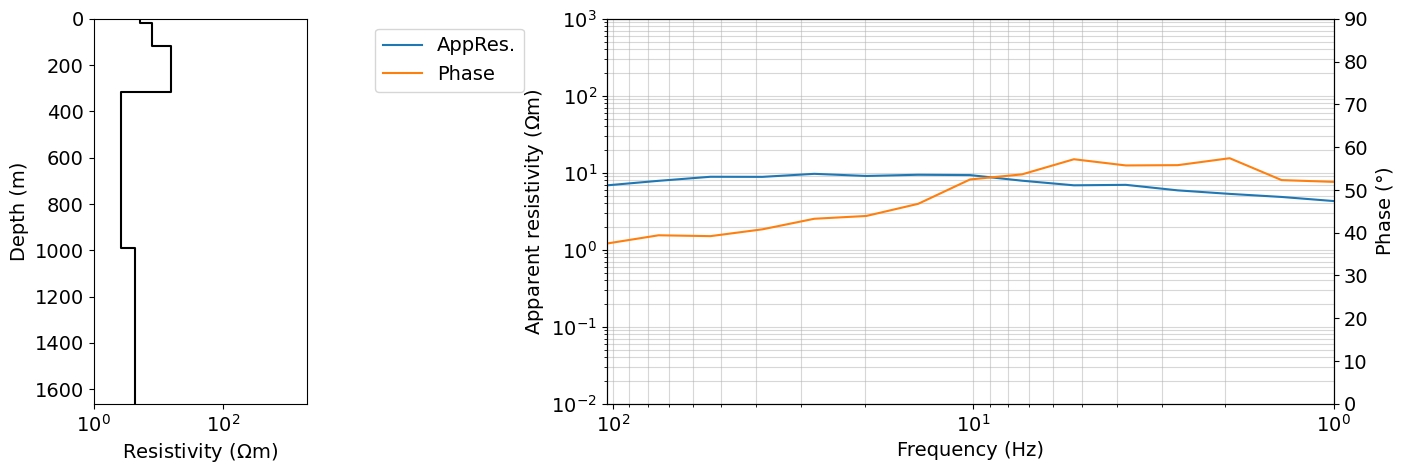

In [26]:

fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 2000)
# ax0.set_yscale('log')
ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='C1')
ax.set_xlabel("Frequency (Hz)")    
ax.set_ylim(0.01, 1000)
ax_1.set_ylim(0, 90)    
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
ax.legend(bbox_to_anchor=(-0.1, 1))
ax.set_xlim(frequencies.max(), frequencies.min())
plt.show()

## Cálculo del Skin Depth

En esta sección creamos un dataframe que contiene las frecuencias de medición y las resistividades aparentes asociadas a cada frecuencia.

In [27]:
df=pd.DataFrame({'Frecuencias': frequencies, 'Resistividad aparente':dobs.reshape((len(frequencies), 2))[:,0]})
print(df)

    Frecuencias  Resistividad aparente
0      1.000000               4.301449
1      1.393386               4.858864
2      1.941524               5.326586
3      2.705293               5.918206
4      3.769517               6.981011
5      5.252392               6.883469
6      7.318609               7.902750
7     10.197648               9.344543
8     14.209259               9.435572
9     19.798982               9.102890
10    27.587623               9.702598
11    38.440207               8.860940
12    53.562044               8.885777
13    74.632600               7.871550
14   103.992017               6.870786


A partir de estas columnas calculamos el Skin depth y extraemos el primer y último dato, que corresponden a la profundidad máxima y mínima respectivamente. 

In [28]:
def calcular_profundidades_piel(df):
    # Calcular la profundidad de piel para cada fila
    df['Profundidad de piel (m)'] = 503 * np.sqrt(df['Resistividad aparente'] / df['Frecuencias'])
    return df
df=calcular_profundidades_piel(df)
print(df)
d_max = df.iloc[0]['Profundidad de piel (m)']
d_min = df.iloc[-1]['Profundidad de piel (m)']

print(f"La profundidad mínima es: {d_min:.2f} metros")
print(f"La profundidad máxima es: {d_max:.2f} metros")

    Frecuencias  Resistividad aparente  Profundidad de piel (m)
0      1.000000               4.301449              1043.218692
1      1.393386               4.858864               939.289880
2      1.941524               5.326586               833.145851
3      2.705293               5.918206               743.970815
4      3.769517               6.981011               684.517058
5      5.252392               6.883469               575.828401
6      7.318609               7.902750               522.688338
7     10.197648               9.344543               481.500810
8     14.209259               9.435572               409.889110
9     19.798982               9.102890               341.064262
10    27.587623               9.702598               298.301104
11    38.440207               8.860940               241.498822
12    53.562044               8.885777               204.874131
13    74.632600               7.871550               163.355529
14   103.992017               6.870786  

### Gráfica

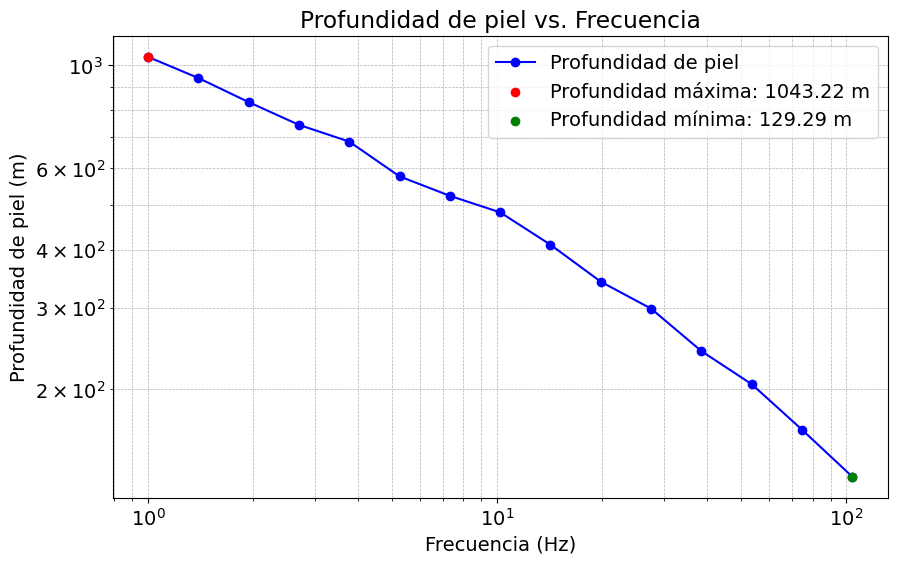

In [29]:
plt.figure(figsize=(10, 6))
plt.loglog(df['Frecuencias'], df['Profundidad de piel (m)'], marker='o', linestyle='-', color='b', label='Profundidad de piel')
plt.scatter(df.iloc[0]['Frecuencias'], d_max, color='r', label=f'Profundidad máxima: {d_max:.2f} m', zorder=5)
plt.scatter(df.iloc[-1]['Frecuencias'], d_min, color='g', label=f'Profundidad mínima: {d_min:.2f} m', zorder=5)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Profundidad de piel (m)')
plt.title('Profundidad de piel vs. Frecuencia')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()